In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

## 1. Data collection 

In [2]:
nasdaq = pd.read_excel("NASDAQ.xlsx")
tickers = nasdaq['Symbol']
tickers_list = list()
for ticker in tickers:
    tickers_list.append(ticker)

In [3]:
#data = yf.download(tickers_list,'2019-01-02','2019-12-31')
#data.to_pickle('ticker_data')

In [4]:
#stock data
data = pd.read_pickle('ticker_data')
data = data.drop(columns = ['Low', 'High', 'Open', 'Close'])
#market index data
index = pd.read_csv('index_ixic.csv', sep=",")
index = index.drop(columns = ['Low', 'High', 'Open', 'Close'])

In [5]:
adj_close = data['Adj Close'] # adjusted closing price
volume = data['Volume'] # sales volume


adj_close.reset_index(level=0, inplace=True) # set index from date to int
volume.reset_index(level=0, inplace=True)

for i in range(0, len(adj_close['Date'])):
    volume.loc[i, 'Date'] = str(volume['Date'][i].date())
    adj_close.loc[i, 'Date'] = str(adj_close['Date'][i].date())


adj_indexes = set(adj_close['Date'].to_list())
ind_indexes = set(index['Date'].to_list())
diff = adj_indexes.difference(ind_indexes)
diff, adj_close.shape, index.shape

C:\Users\Katya\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


({'2019-11-28'}, (252, 5014), (251, 3))

In [6]:

adj_close = adj_close.loc[adj_close['Date'] != '2019-11-28']
volume = volume.loc[volume['Date'] != '2019-11-28']

#handling missing values
adj_close = adj_close.dropna(axis=1, how='any')
volume = volume.dropna(axis=1, how='any')

#add the index data to the main data
adj_close['IXIC'] = index['Adj Close']
volume['IXIC'] = index['Volume']

#delete last day as ixic is nan
adj_close = adj_close.loc[adj_close['Date'] != '2019-12-30']
volume = volume.loc[volume['Date'] != '2019-12-30']

#reindex after drop
adj_close.reset_index(drop=True, inplace=True)

In [7]:
#reduce the number of tickers
tickers_to_delete = adj_close.columns.to_list()
tickers_to_delete.remove('Date')
tickers_to_delete.remove('IXIC')
tickers_to_delete = tickers_to_delete[::2]
adj_close.drop(tickers_to_delete, inplace=True, axis=1) 
volume.drop(tickers_to_delete, inplace=True, axis=1) 

## 2. Logarithmic returns, expected value and standard deviation estimations


In [8]:
# calculate logarithmic returns
log_returns = pd.DataFrame(index = adj_close.index, columns = adj_close.columns)
log_returns['Date'] = adj_close['Date']
tickers = adj_close.columns.to_list()
tickers.remove('Date')


num_days=len(log_returns['AADR'])
for ticker in tickers:
    for i in range(1, num_days):
        log_returns.loc[i, ticker] = np.log(adj_close.loc[i, ticker]/adj_close.loc[i-1, ticker])
#droping first day
log_returns = log_returns.dropna(axis=0, how='any')
log_returns.reset_index( drop=True, inplace=True) 


In [9]:
log_returns

,Date,AADR,AAOI,AAPL,AAXJ,ABEO,ABMD,ABUS,ACB,ACER,...,ZBRA,ZEST,ZG,ZION,ZIOP,ZKIN,ZNGA,ZSAN,ZYNE,IXIC
0,2019-01-03,-0.0112208,-0.0530182,-0.104924,-0.0239004,-0.0600914,-0.0250564,-0.0592194,-0.0192684,-0.0501898,...,-0.0617774,0.057894,-0.0109327,-0.00554689,-0.0275246,-0.0651332,-0.0151902,0.0294759,-0.013532,-0.03084
1,2019-01-04,0.0381305,0.0313751,0.0418032,0.0324233,0.0586679,0.0362211,0.083912,0.0154443,0.0525181,...,0.0406259,0.117783,0.0259755,0.030251,0.041008,0.126881,0.0251902,0.0911522,0.0861027,0.0417198
2,2019-01-07,0.0117576,0.00896869,-0.00222819,0.00595423,0.0674723,0.00432952,0.0240975,0.00763362,0.0713467,...,0.0150525,-0.0454623,0.00550252,0.00398099,0.013304,0.0178047,0.0123611,0.0298529,0,0.0124774
3,2019-01-08,0.00689408,0.0208275,0.0188837,0.00265223,-0.0269922,0.0114338,-0.0363676,-0.044711,0.0176008,...,0.00667488,-0.0723207,0.0264389,0.00907301,-0.0358783,-0.0923734,0.0170527,0.0182154,0.0295588,0.0107184
4,2019-01-09,0.0166807,0.00684725,0.0168391,0.0169942,0,0.0549296,-0.0584665,0.0801956,0.00424631,...,0.0245163,-0.0645385,0.0233039,0.00853228,0.0314632,0.166061,0.0309181,0.0143371,0.0357607,0.00867332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2019-12-20,0.0082443,-0.0160575,-0.00207335,0.00315572,-0.471605,-0.0393647,0.237081,-0.00884961,-0.0333793,...,-0.00253154,0.0151136,-0.0202348,0.00271527,-0.0336999,-0.0540673,-0.00318979,-0.00722024,-0.00801932,0.00231558
245,2019-12-23,0.00242295,0.00269419,0.0161868,0.000410782,0.1514,0.0453082,-0.0496556,-0.112795,0.0155444,...,0.0166533,0,0.0127797,-0.00563265,0,0.0389154,0.00318979,0.0215062,-0.0244511,0.000807831
246,2019-12-24,0.00519865,-0.00269419,0.000950071,-0.00301693,-0.00829886,0.0108538,0,-0.0100002,0.0203569,...,-0.00939235,0,0.0135138,0.00369387,0.0433993,0.00760468,0.00793021,-0.0142859,-0.00995032,0.00773397
247,2019-12-26,0.00554022,0.0431215,0.0196462,0.00616143,0,-0.00751516,-0.0484266,0.00501258,-0.0126744,...,0.000353794,0,0.0137749,0.00251982,-0.0454175,-0.00760468,-0.00475056,0.00716848,-0.0219049,-0.00174935


In [10]:
#calculate the estimates of the mathematical expectation and std for each stock
ListOfStats = ['Mean', 'Std']

stats = pd.DataFrame(columns = ListOfStats, index = tickers)

for ticker in tickers:
    mean = np.mean(log_returns[ticker]) # 
    std = np.std(log_returns[ticker], ddof = 1) # variance (дисперсия), должно быть стандартное отклонение 
    #std2 = np.std(log_returns[ticker])

    stats['Mean'][ticker] = mean
    stats['Std'][ticker] = std

stats

,Mean,Std
AADR,0.00123549,0.00851074
AAOI,-0.00128906,0.0360411
AAPL,0.00249805,0.0166611
AAXJ,0.000701248,0.00977426
ABEO,-0.00289376,0.0743709
...,...,...
ZKIN,-0.000788889,0.0445391
ZNGA,0.00181245,0.0156228
ZSAN,-0.00214996,0.0820995
ZYNE,0.00175588,0.0539614


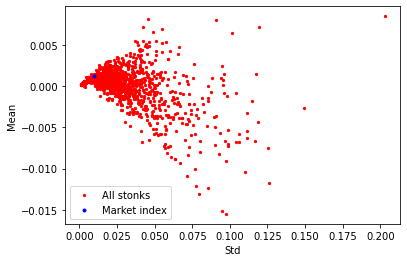

In [11]:
stats.plot(x='Std', y='Mean', color="red", kind="scatter", marker=".", label='All stonks') # лайк за стонкс) 
plt.scatter(stats['Std']['IXIC'], stats['Mean']['IXIC'], marker=".", color="blue", label='Market index')
plt.legend()
plt.show()

## 3-4. Equally weighted portfolio, stock market index  

In [12]:
#equally weighted portfolio return
sum_returns = 0
for ticker in tickers:
    sum_returns += stats['Mean'][ticker]
    
mean_balanced = sum_returns/len(tickers)
for i in range(len)

var_balanced = np.var(balanced_return) # std

SyntaxError: invalid syntax (<ipython-input-12-b7c357696869>, line 7)

In [ ]:
stats.plot(x='Std', y='Mean', color="red", kind="scatter", label='All stonks')
plt.scatter(stats['Std']['IXIC'], stats['Mean']['IXIC'], color="blue", label='Market index')
plt.scatter(var_balanced, mean_balanced, color="green", label='Balanced portfolio')
plt.legend()
plt.show()

# 5. VaR

In [ ]:
#VaR_gam = mu + sigma*U_gamma where U_gamma is Z-score? wtf

gamma1 = 0.95
gamma2 = 0.90

gamma_quantile1 = scipy.stats.norm.ppf(gamma1) # percentage point function
gamma_quantile2 = scipy.stats.norm.ppf(gamma2)

z_score1, z_score2

VaR1 = stats['Std']*gamma_quantile1 + stats['Mean']
VaR2 = stats['Std']*gamma_quantile2 + stats['Mean']

## 6. White noise

## 7. 

## 8. 